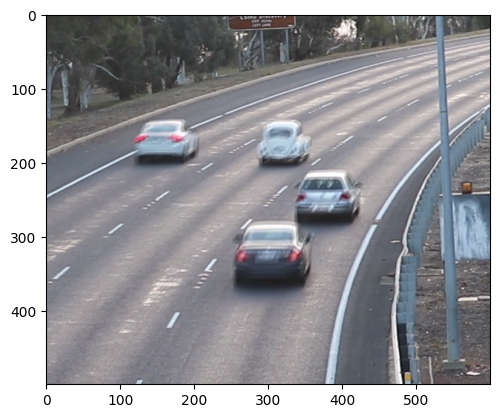

In [75]:
import pickle
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from mcf.data_types import Frame, DetectionRegion, BoundingBox, Point
from mcf.common import MinHeap, euclidean_distance
from mcf.region_matching.region_matching_status import RegionMatchingStatus
from dataclasses import dataclass

GREEN = (0,255,0)
RED = (0,0,255)
PURPLE = (200, 0, 256)
BLUE = (255,0,0)

with open("./data/current_frame_matching.pickle", "rb") as f:
    current_frame: Frame = pickle.load(f)

with open("./data/last_frame_matching.pickle", "rb") as f:
    last_frame: Frame = pickle.load(f)

def add_bounding_box(image: np.array, bbox: BoundingBox, bbox_color):
    # add bounding box
    cv.rectangle(image, (bbox.upper_left.x, bbox.upper_left.y), (bbox.lower_right.x, bbox.lower_right.y), bbox_color, 1)

alpha = 0.5
blended_image = cv.addWeighted(last_frame.image, alpha, current_frame.image, 1 - alpha, 0)
plt.imshow(blended_image[300:800,1000:1600,::-1])

# entry point
dynamic programming solution to finding optimal match set

In [102]:
@dataclass
class Match:
    total_cost: float
    cost: float
    last_index: int
    current_index: int

def region_matching(last_detection_regions: list[DetectionRegion], last_image: np.array, current_detection_regions: list[DetectionRegion], current_image: np.array) -> RegionMatchingStatus:

    # preprocess last detection regions, there may be unpredicted values

    matches = _get_optimal_matches(last_detection_regions=last_frame.detection_regions \
                                 , last_image=last_image \
                                 , last_available=np.arange(len(last_detection_regions)).tolist() \
                                 , current_detection_regions=current_detection_regions \
                                 , current_image=current_image \
                                 , current_index=0 \
                                 , memo = {})

    # filter optimal matches
        # invalid matches may exist
        # unmatched in current are considered new targets and are left unmatched
        # unmatched in last are either expected in view or out of view
            # if in view and confidence is above a threshold, create dummy match with decaying confidence

    
    # assign matches to current dection regions
    status = _assign_matches(last_detection_regions=last_detection_regions, current_detection_regions=current_detection_regions, matches=matches)

    return status

def _get_optimal_matches(last_detection_regions: list[DetectionRegion], last_image: np.array, last_available: list[int], current_detection_regions: list[DetectionRegion], current_image: np.array, current_index: int, memo: dict[tuple]) -> RegionMatchingStatus:
    """ dynamic programming algorithm that finds the optimal (minimum cost) set of matches """
    if (current_index >= len(current_detection_regions)) or (len(last_available) == 0):
        return None

    match_permutation_choices = MinHeap()

    current = current_detection_regions[current_index]

    for last_index in last_available:
        last = last_detection_regions[last_index]
        match: Match = get_match(last=last, last_image=last_image, current=current, current_image=current_image)
        match.last_index = last_index
        match.current_index = current_index

        last_remaining = last_available.copy()
        last_remaining.remove(last_index)

        memo_index = _memo_hash(last_remaining, current_index)
        if memo_index in memo:
            sub_match_permutation = memo[memo_index]

        else:
            # subproblems
            sub_match_permutation = _get_optimal_matches(last_detection_regions=last_frame.detection_regions \
                                                       , last_image=last_frame.image \
                                                       , last_available=last_remaining \
                                                       , current_detection_regions=current_frame.detection_regions \
                                                       , current_image=current_frame.image \
                                                       , current_index=current_index + 1
                                                       , memo=memo)
            memo[memo_index] = sub_match_permutation

        if sub_match_permutation is not None:
            match.total_cost = match.cost + sub_match_permutation[0].total_cost
            match_permutation_choices.push(match.total_cost, [match] + sub_match_permutation)
        else:
            match.total_cost = match.cost
            match_permutation_choices.push(match.cost, [match])
        

    _, best_match_permutation = match_permutation_choices.pop()
    
    return best_match_permutation
    
def _assign_matches(last_detection_regions: list[DetectionRegion], current_detection_regions: list[DetectionRegion], matches: list[Match]) -> RegionMatchingStatus:
    for match in matches:
        last = last_detection_regions[match.last_index]
        current = current_detection_regions[match.current_index]
        
        if current.predicted_bounding_box is not None:
            return RegionMatchingStatus.ERROR_CONFLICTING_MATCH
        if current.predicted_center_of_mass is not None:
            return RegionMatchingStatus.ERROR_CONFLICTING_MATCH

        current.predicted_bounding_box = last.next_bounding_box
        current.predicted_center_of_mass = last.next_center_of_mass
        current.velocities += last.velocities
    return RegionMatchingStatus.SUCCESS

def _memo_hash(last_remaining: list[int], current_index: int):
    vals = last_remaining.copy()
    vals.append(current_index)
    return int(''.join(map(str, vals)))

# Cost functions
these method define the quantity minimized by the dynamic programming algorithm

In [103]:
def get_match(last: DetectionRegion, last_image: np.array, current: DetectionRegion, current_image: np.array) -> Match:
    predicted_com = last.next_center_of_mass
    predicted_bbox = last.next_bounding_box
    predicted_com = Point(predicted_com.x + predicted_bbox.upper_left.x, predicted_com.y + predicted_bbox.upper_left.y)
    predicted_mask = last.mask

    measured_com = current.center_of_mass
    measured_bbox = current.bounding_box
    measured_com = Point(measured_com.x + measured_bbox.upper_left.x, measured_com.y + measured_bbox.upper_left.y)
    measured_mask = current.mask

    # center of mass distance
    dist = euclidean_distance(predicted_com, measured_com)
    
    # iou of bounding box
    iou = intersection_over_union(predicted_bbox, measured_bbox)

    # mask correlation
    # correlation = correlate_mask_regions(last.mask, last.bounding_box, last_image, current.mask, current.bounding_box, current_image)

    cost = dist + (1-iou)
    return Match(None, cost, None, None)

def intersection_over_union(b1: BoundingBox, b2: BoundingBox) -> float:
    intersection_area = max(0, min(b1.lower_right.x, b2.lower_right.x) \
                        - max(b1.upper_left.x, b2.upper_left.x)) * max(0, min(b1.lower_right.y, b2.lower_right.y) \
                        - max(b1.upper_left.y, b2.upper_left.y))
    union_area = b1.area() + b2.area() - intersection_area
    iou = intersection_area / union_area
    return iou

def correlate_mask_regions(last_mask: np.array, last_bbox: BoundingBox, last_image: np.array, current_mask: np.array, current_bbox: BoundingBox, current_image: np.array, mask_threshold:float=0.5) -> float:
    x_start = min(last_bbox.upper_left.x, current_bbox.upper_left.x)
    y_start = min(last_bbox.upper_left.y, current_bbox.upper_left.y)
    x_end = max(last_bbox.lower_right.x, current_bbox.lower_right.x)
    y_end = max(last_bbox.lower_right.y, current_bbox.lower_right.y)

    # extract mask of image over the same region in both images
    last_mask_patch = np.zeros_like(last_image)
    (last_mask_patch[last_bbox.upper_left.y:last_bbox.lower_right.y, last_bbox.upper_left.x:last_bbox.lower_right.x])\
        = (last_image[last_bbox.upper_left.y:last_bbox.lower_right.y, last_bbox.upper_left.x:last_bbox.lower_right.x]) * np.repeat(last_mask[:,:,np.newaxis], 3, axis=2)
    
    last_mask_patch = last_mask_patch[y_start:y_end, x_start:x_end, :]

    current_mask_patch = np.zeros_like(current_image)
    (current_mask_patch[current_bbox.upper_left.y:current_bbox.lower_right.y, current_bbox.upper_left.x:current_bbox.lower_right.x])\
        = (current_image[current_bbox.upper_left.y:current_bbox.lower_right.y, current_bbox.upper_left.x:current_bbox.lower_right.x]) * np.repeat(current_mask[:,:,np.newaxis], 3, axis=2)
    
    current_mask_patch = current_mask_patch[y_start:y_end, x_start:x_end, :]

    # trim non overlapping mask sections
    # last_mask_patch[current_mask_patch == 0] = 0
    # current_mask_patch[last_mask_patch == 0] = 0

    plt.figure()
    plt.imshow(last_mask_patch)
    plt.figure()
    plt.imshow(current_mask_patch)
    plt.show()

    current_mask_patch = current_image.copy()
    (current_mask_patch[current_bbox.upper_left.y:current_bbox.lower_right.y, current_bbox.upper_left.x:current_bbox.lower_right.x, :])[current_mask == 0] = 0
    current_mask_patch = current_mask_patch[y_start:y_end, x_start:x_end, :]


get_match(last_frame.detection_regions[1], last_frame.image, current_frame.detection_regions[0], current_frame.image)

Match(total_cost=None, cost=6.424476642130622, last_index=None, current_index=None)

# Dummy Matching
these methods handle unmatchable targets

reasons include,
- occlusion
- detection stage dropout
- moving out of field of view

In [104]:
def is_valid_match() -> bool:
    match_status = True
    # TODO: need a way to invalidate matches
    # idea: look at variance of measurement (can estimate from cOm maybe?), and variance of prediction (velocity vector)
    #   invalid if they do no interset within a constant multiple of standard deviations
    return match_status

def make_phantom_detection_region(detection_region: DetectionRegion) -> DetectionRegion:
    if (detection_region.confidence) < 0.25: # TODO: establish threshold
        return None
    phantom_detection = DetectionRegion(classification=detection_region.classification,
                                        confidence=detection_region.confidence/2.0,
                                        mask=detection_region.mask,
                                        center_of_mass=detection_region.next_center_of_mass,
                                        bounding_box=detection_region.next_bounding_box,
                                        next_bounding_box=None,
                                        next_center_of_mass=None,
                                        predicted_bounding_box=detection_region.next_bounding_box,
                                        predicted_center_of_mass=detection_region.next_center_of_mass,
                                        velocities=detection_region.velocities)
    return phantom_detection


# run target matching with example data

In [105]:
with open("./data/current_frame_matching.pickle", "rb") as f:
    current_frame: Frame = pickle.load(f)

with open("./data/last_frame_matching.pickle", "rb") as f:
    last_frame: Frame = pickle.load(f)
    
status = region_matching(last_detection_regions=last_frame.detection_regions \
                       , last_image=last_frame.image \
                       , current_detection_regions=current_frame.detection_regions \
                       , current_image=current_frame.image)

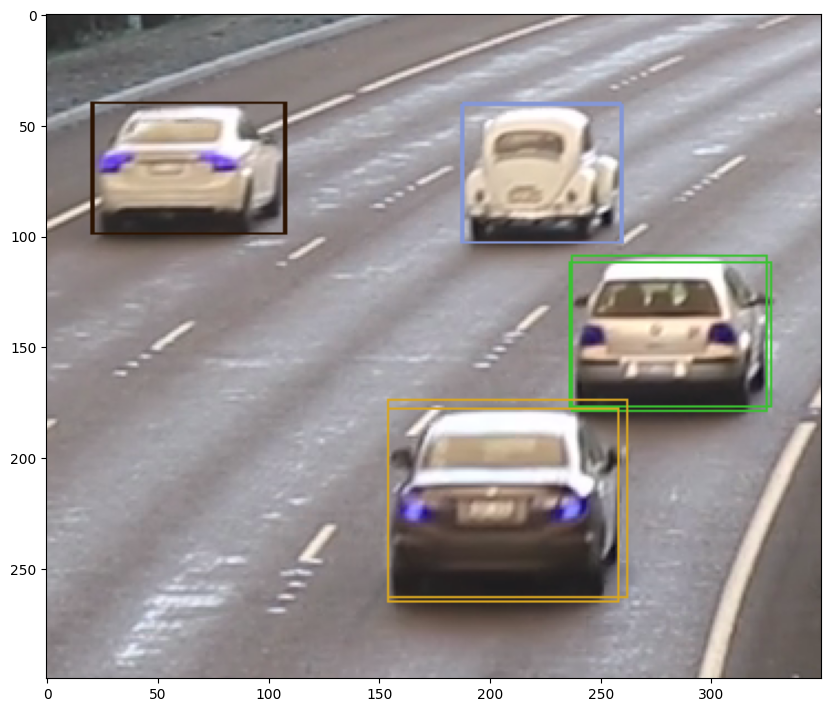

In [106]:
plot_image = current_frame.image.copy()

if status == RegionMatchingStatus.SUCCESS:
    for current in current_frame.detection_regions:

        color = (np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255))
        
        # add_bounding_box(plot_image, last.bounding_box, color)
        add_bounding_box(plot_image, current.predicted_bounding_box, color)
        add_bounding_box(plot_image, current.bounding_box, color)
        

    plt.figure(figsize=(10,10))
    plt.imshow(plot_image[400:700,1100:1450])
